In [16]:
import cv2
import numpy as np
import face_recognition
from PIL import Image
import glob
import re
import ntpath
import os
import dlib
import time
from imutils.face_utils import FaceAligner
import sqlite3
from imutils.face_utils import rect_to_bb
import imutils
from imutils import face_utils
import os
import shutil
import inception_resnet_v1
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
shutil.rmtree("../data/unknown_people/")

In [3]:
os.mkdir("../data/unknown_people/")

In [4]:
people = sqlite3.connect('people.db')
c = people.cursor()

In [5]:
# show name people know name
for row in c.execute('select * from people_known order by old'):
    print(row)

('Phạm Minh Anh', 0, 9)
('Dam Thi Phuong Linh', 0, 11)
('Dam Van Tai', 1, 24)
('vietnam', 1, 24)
('ha thi quynh huong', 1, 24)
('Pham Van Tuan', 1, 30)
('dam van tai', 1, 40)


In [6]:
# show name people in room equal empty
c.execute('delete from people_inroom')
people.commit()
for row in c.execute('select * from people_inroom order by old'):
    print(row)

In [7]:
# show name people in room equal empty
# c.execute('delete from people_inroom')
# people.commit()
# for row in c.execute('select * from people_inroom order by old'):
#     print(row)

In [8]:
# show id people unknown name
c.execute('delete from people_unknown')
people.commit()
for row in c.execute('select * from people_unknown order by old'):
    print(row)

In [9]:
# show id people unknown name
# c.execute('delete from people_unknown')
# people.commit()
# for row in c.execute('select * from people_unknown order by old'):
#     print(row)

In [10]:
# recognition face center
def face_center(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(image_gray, 1)
    for (i, rect) in enumerate(rects):
        points = predictor(image_gray, rect)
        points = face_utils.shape_to_np(points)
        center_face = points[37][1] - points[46][1]
        if center_face < 10 & center_face > -10:
            return True
        else:
            return False

In [20]:
def _css_to_rect(css):
    """
    Convert a tuple in (top, right, bottom, left) order to a dlib `rect` object
    :param css:  plain tuple representation of the rect in (top, right, bottom, left) order
    :return: a dlib `rect` object
    """
    return dlib.rectangle(css[3], css[0], css[1], css[2])

In [12]:
tf.reset_default_graph() 
sess = tf.Session()
images_pl = tf.placeholder(tf.float32, shape=[None, 160, 160, 3], name='input_image')
images_norm = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), images_pl)
train_mode = tf.placeholder(tf.bool)
age_logits, gender_logits, _ = inception_resnet_v1.inference(images_norm, keep_probability=0.8,
                                                             weight_decay=1e-5)
gender = tf.argmax(tf.nn.softmax(gender_logits), 1)
age_ = tf.cast(tf.constant([i for i in range(0, 101)]), tf.float32)
age = tf.reduce_sum(tf.multiply(tf.nn.softmax(age_logits), age_), axis=1)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state("../gender_age_tf/models/")
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("restore model!")
else:
    pass

INFO:tensorflow:Restoring parameters from ../gender_age_tf/models/model.ckpt-14001
restore model!


In [14]:
# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
name = ""
frame_number = 0
total_in_room = 0
total_known_in_room = 0
index = 0

# Load known_face_encoding_array and known_face name from npy
known_face_encodings_array = np.load("../data/numpy/known_face_encoding.npy")
known_face_names = np.load("../data/numpy/known_face_names.npy")

# Convert nparray -> list 
number_person = len(known_face_encodings_array)
known_face_encodings_array = known_face_encodings_array.reshape(number_person, 128)
known_face_encodings = []
for i in range(len(known_face_encodings_array)):
    known_face_encodings.append(known_face_encodings_array[i])

# face encodings of people in room
face_encodings_in_room = []
face_encodings_unknown_in_room = []
face_names_unknown_in_room = []
# known_face_encodings: array known_face_encodings 

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=160)

# Capture from camera of own computer
video_capture = cv2.VideoCapture(0)

while True:
    # Grab a single frame of video
    ret, frame = video_capture.read()

    frame_number += 1
    
    # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
    rgb_small_frame = frame[:, :, ::-1]
        
    # Use computer configuration low
#     if (frame_number % 3 == 0):
    # Only process every other frame of video to save time
#     if process_this_frame:

    # Find all the faces and face encodings in the current frame of video
    face_locations = face_recognition.face_locations(rgb_small_frame)
#         print(face_locations)
    face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

    face_names = []
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        face_unknown = frame[top:bottom, left-20:right+20]
        
        # test face center to process
        if face_center(face_unknown) == True:
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=0.4)

#             print(face_recognition.face_distance(known_face_encodings, face_encoding))
#             print(matches)
#             print(np.min(face_recognition.face_distance(known_face_encodings, face_encoding)))

            distance = face_recognition.face_distance(known_face_encodings, face_encoding)
            point = np.min(distance)
#             print(distance)
            index_point_min = np.argmin(distance)
#             print("gia tri cua index_point_min", index_point_min)
            if point > 0.4:
                if os.path.isfile("../data/unknown_people/unknown_0.jpg"):
                    distance_unknown = face_recognition.face_distance(face_encodings_unknown_in_room, face_encoding)
                    min_distance_unknown = np.min(distance_unknown)
                    if min_distance_unknown > 0.6:
                        a = os.listdir("../data/unknown_people/")
                        a.sort()
                        index = int(a[-1].split('.')[0].split('_')[1])
                        index += 1
                        print("gia tri index", index)
                        path = "../data/unknown_people/unknown_" + str(index) + ".jpg"
                        name = "unknown_" + str(index)
                        cv2.imwrite(path, face_unknown)
                        face_encodings_unknown_in_room.append(face_encoding)
                        face_names_unknown_in_room.append(name)
                        total_in_room += 1
                        print(name)

                        # Draw a rectangle with detect the face
                        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                        # Draw a label with a name below the face
                        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                        font = cv2.FONT_HERSHEY_DUPLEX
                        cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
                        
                        # estimate gender and age
                        
                        c.execute("insert into people_inroom values ('%s', 1, 12)" % name)
                        people.commit()
                        c.execute("insert into people_unknown values ('%s', 1, 12)" % name)
                        people.commit()
                else:
                    name = "unknown_0"
                    path = "../data/unknown_people/unknown_0" + ".jpg"
                    cv2.imwrite(path, face_unknown)
                    face_encodings_unknown_in_room.append(face_encoding)
                    face_names_unknown_in_room.append(name)
                    total_in_room += 1
                    print(name)

                    # Draw a rectangle with detect the face
                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                    # Draw a label with a name below the face
                    cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

                    c.execute("insert into people_inroom values ('%s', 1, 12)" % name)
                    people.commit()
                    c.execute("insert into people_unknown values ('%s', 1, 12)" % name)
                    people.commit()

            # If a match was found in known_face_encodings, just use the first one.
            if True in matches:
#                 first_match_index = matches.index(True)
#                 print("gia tri cua first_match_index", first_match_index)
#                 first_match_index = matches[index_point_min]
#                 name = known_face_names[first_match_index]
                name = known_face_names[index_point_min]

                # Draw a rectangle with detect the face
                cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

                # Draw a label with a name below the face
                cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

                print(name)
                c.execute("select * from people_known where name= '%s'" % name)
                data_temp = c.fetchone()  # name in people known
                c.execute("select * from people_inroom where name='%s'" % name)
                data_name_inroom = c.fetchone() # name in room
                if data_name_inroom == None:
                    c.execute("insert into people_inroom values (?, ?, ?)", data_temp)
                    people.commit()
                    total_in_room += 1
                    total_known_in_room += 1
            face_names.append(name)

        print("total in people in room ", total_in_room)
        print("total in people known name in room ", total_known_in_room)
    # Display the resulting image
    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
people.close()

Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1
Dam Van Tai
total in people in room  1
total in people known name in room  1

total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in people in room  2
total in people known name in room  1
Dam Van Tai
total in pe

KeyboardInterrupt: 

In [233]:
import tensorflow as tf
import inception_resnet_v1
import cv2
import dlib
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import numpy as np
import face_recognition
import matplotlib.pyplot as plt

In [234]:
tf.reset_default_graph() 
# sess = tf.InteractiveSession()
sess = tf.Session()
images_pl = tf.placeholder(tf.float32, shape=[None, 160, 160, 3], name='input_image')
images_norm = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), images_pl)
train_mode = tf.placeholder(tf.bool)
age_logits, gender_logits, _ = inception_resnet_v1.inference(images_norm, keep_probability=0.8,
                                                             phase_train=train_mode,
                                                             weight_decay=1e-5)

gender = tf.argmax(tf.nn.softmax(gender_logits), 1)
age_ = tf.cast(tf.constant([i for i in range(0, 101)]), tf.float32)
age = tf.reduce_sum(tf.multiply(tf.nn.softmax(age_logits), age_), axis=1)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state("../gender_age_tf/models/")
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("restore model!")
else:
    pass

INFO:tensorflow:Restoring parameters from ../gender_age_tf/models/model.ckpt-14001
restore model!


In [339]:
image = cv2.imread("../data/pictures_of_people_i_know/unknown_1.jpg", cv2.COLOR_RGB2BGR)

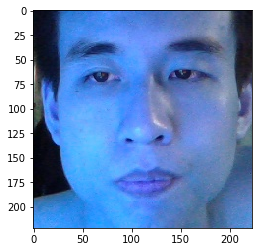

In [340]:
plt.imshow(image)

In [315]:
image.shape

(222, 223, 3)

In [316]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [317]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=160)

In [318]:
# use face_location

In [319]:
face_location = face_recognition.face_locations(image)

In [320]:
face_location

[(15, 201, 201, 15)]

In [321]:
def _css_to_rect(css):
    """
    Convert a tuple in (top, right, bottom, left) order to a dlib `rect` object
    :param css:  plain tuple representation of the rect in (top, right, bottom, left) order
    :return: a dlib `rect` object
    """
    return dlib.rectangle(css[3], css[0], css[1], css[2])

In [322]:
face_detector = _css_to_rect(face_location[0])

In [323]:
face_detector

rectangle(15,15,201,201)

In [324]:
# use detector

In [325]:
detected = detector(image_gray, 2)

In [326]:
detected

rectangles[[(15, 16) (208, 208)]]

In [327]:
faces = np.empty((1, 160, 160, 3))
# face = np.empty((160, 160, 3))

In [328]:
# type(faces[0])
faces[0].shape

(160, 160, 3)

In [329]:
face = fa.align(image, image_gray, detected[0])

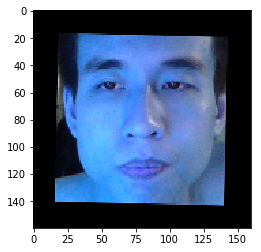

In [330]:
plt.imshow(face)

In [331]:
face_loca = fa.align(image, image_gray, face_detector)

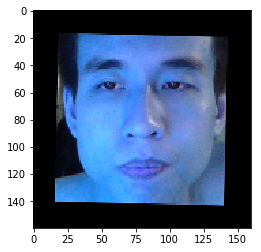

In [332]:
plt.imshow(face_loca)

In [333]:
faces[0, :, :, :] = fa.align(image, image_gray, detected[0])

In [334]:
sess.run([age, gender], feed_dict={images_pl: faces, train_mode: False})

[array([ 25.02889061], dtype=float32), array([1])]